In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold , StratifiedKFold, cross_val_score
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import optuna

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mai-ml-contest-1/ex.csv
/kaggle/input/mai-ml-contest-1/train.csv
/kaggle/input/mai-ml-contest-1/test.csv
/kaggle/input/dataset-1/train.csv
/kaggle/input/dataset-1/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/mai-ml-contest-1/train.csv')
train.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


# EDA
Проверим пропущенные значения.

<Axes: >

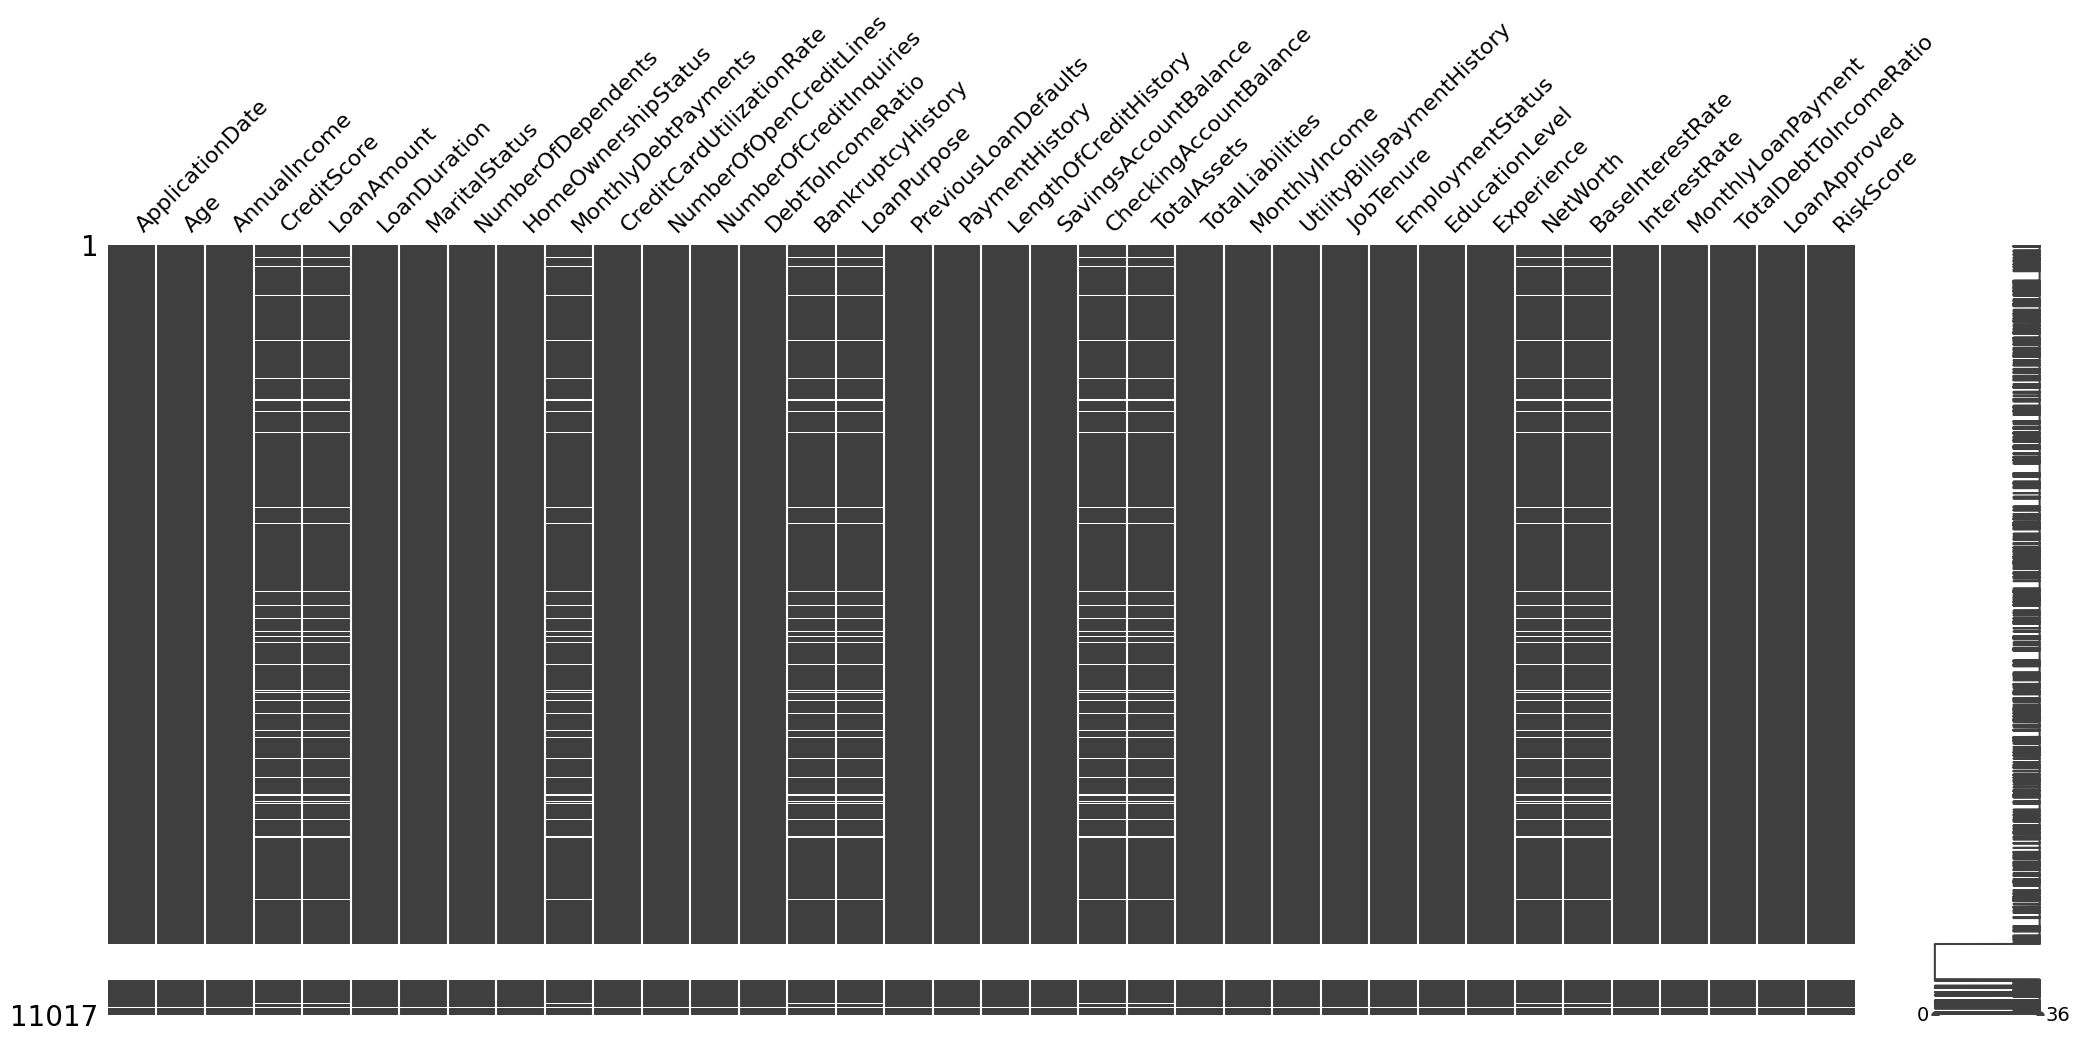

In [4]:
msno.matrix(train)

Видим, что все пропуски встречаются вместе, так что можно просто удалить строки с пропущенными значениями.
Заодно удалим столбец с датами и повторяющиеся строчки.

In [5]:
df = train.dropna()
df = df.drop(columns=['ApplicationDate'])
print(train.shape, df.shape)
df = df.drop_duplicates()
print(train.shape, df.shape)

(11017, 36) (9986, 35)
(11017, 36) (9529, 35)


In [6]:
num_features = df.select_dtypes(include=np.number).columns.tolist()
cat_features = df.select_dtypes(include='object').columns.tolist()
num_features.remove('RiskScore')

print(num_features)
print(cat_features)

['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']
['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


Рассмотрим данные о всех столбцах. Заметим выбросы в таргете и почистим их.

In [7]:
pd.set_option('display.max_columns', None)
df.describe()

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
count,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9.529000e+03,9.529000e+03,9529.000000,9529.000000,9529.000000,9529.000000,9.529000e+03,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9.529000e+03
mean,39.875223,131707.601952,678.223318,29757.317137,53.418827,1.568265,547.004093,0.284779,3.034841,0.981320,0.250427,0.052157,0.095603,24.005877,15.622206,5497.719593,1981.965159,1.822949e+05,6.878936e+04,10842.082135,0.783746,4.948368,17.647917,1.533819e+05,0.200161,0.199828,1068.863223,0.510345,0.513275,-3.458380e+04
std,11.595208,115989.243989,175.036220,27212.871160,24.393468,1.419023,502.780983,0.159266,1.740828,0.990333,0.144648,0.222354,0.294061,4.843561,8.654726,8491.101806,3021.471885,4.624953e+05,2.025591e+05,9383.125417,0.123648,2.205838,11.326066,4.571673e+05,0.093944,0.096018,1301.572948,0.843369,0.499850,1.437496e+06
min,18.000000,15000.000000,300.000000,1063.000000,12.000000,0.000000,13.000000,0.003674,0.000000,0.000000,0.003227,0.000000,0.000000,8.000000,1.000000,31.000000,16.000000,8.920000e+02,7.800000e+01,1250.000000,0.259301,0.000000,0.000000,1.004000e+03,0.052494,0.046445,30.008506,0.006064,0.000000,-9.999999e+06
25%,32.000000,21067.000000,550.000000,12633.000000,36.000000,0.000000,234.000000,0.159134,2.000000,0.000000,0.138390,0.000000,0.000000,21.000000,8.000000,1404.000000,532.000000,2.311100e+04,8.037000e+03,1711.333333,0.707136,3.000000,9.000000,7.303000e+03,0.120089,0.119684,374.710650,0.066347,0.000000,3.249476e+01
50%,40.000000,88998.000000,723.000000,21803.000000,48.000000,1.000000,399.000000,0.263013,3.000000,1.000000,0.228363,0.000000,0.000000,24.000000,16.000000,2986.000000,1123.000000,6.095100e+04,2.266300e+04,7371.250000,0.803587,5.000000,17.000000,2.763100e+04,0.182014,0.180283,684.613633,0.177859,1.000000,4.401980e+01
75%,48.000000,257409.000000,850.000000,37086.000000,60.000000,3.000000,687.000000,0.392255,4.000000,2.000000,0.340925,0.000000,0.000000,27.000000,23.000000,6256.000000,2297.000000,1.614410e+05,6.021600e+04,21273.666667,0.878992,6.000000,26.000000,1.237390e+05,0.264311,0.264806,1279.858303,0.638523,1.000000,6.526522e+01
max,80.000000,748508.000000,850.000000,418997.000000,120.000000,6.000000,10879.000000,0.914635,12.000000,6.000000,0.865842,1.000000,1.000000,44.000000,30.000000,222556.000000,109245.000000,1.128946e+07,8.997054e+06,25000.000000,0.996573,17.000000,57.000000,1.126117e+07,0.722497,0.833647,29634.807816,24.383046,1.000000,1.000000e+07


In [8]:
q_low = df['RiskScore'].quantile(0.01)
q_hi = df['RiskScore'].quantile(0.99)
df = df[(df['RiskScore'] < q_hi) & (df['RiskScore'] > q_low)]
df['RiskScore']

0       66.176500
1       28.495737
2       34.488104
3       36.910753
4       31.347091
          ...    
9994    34.037970
9995    76.185933
9996    41.213393
9997    43.699684
9999    56.104270
Name: RiskScore, Length: 9318, dtype: float64

Построим матрицу корреляций и выбросим сильно коррелирующие признаки.

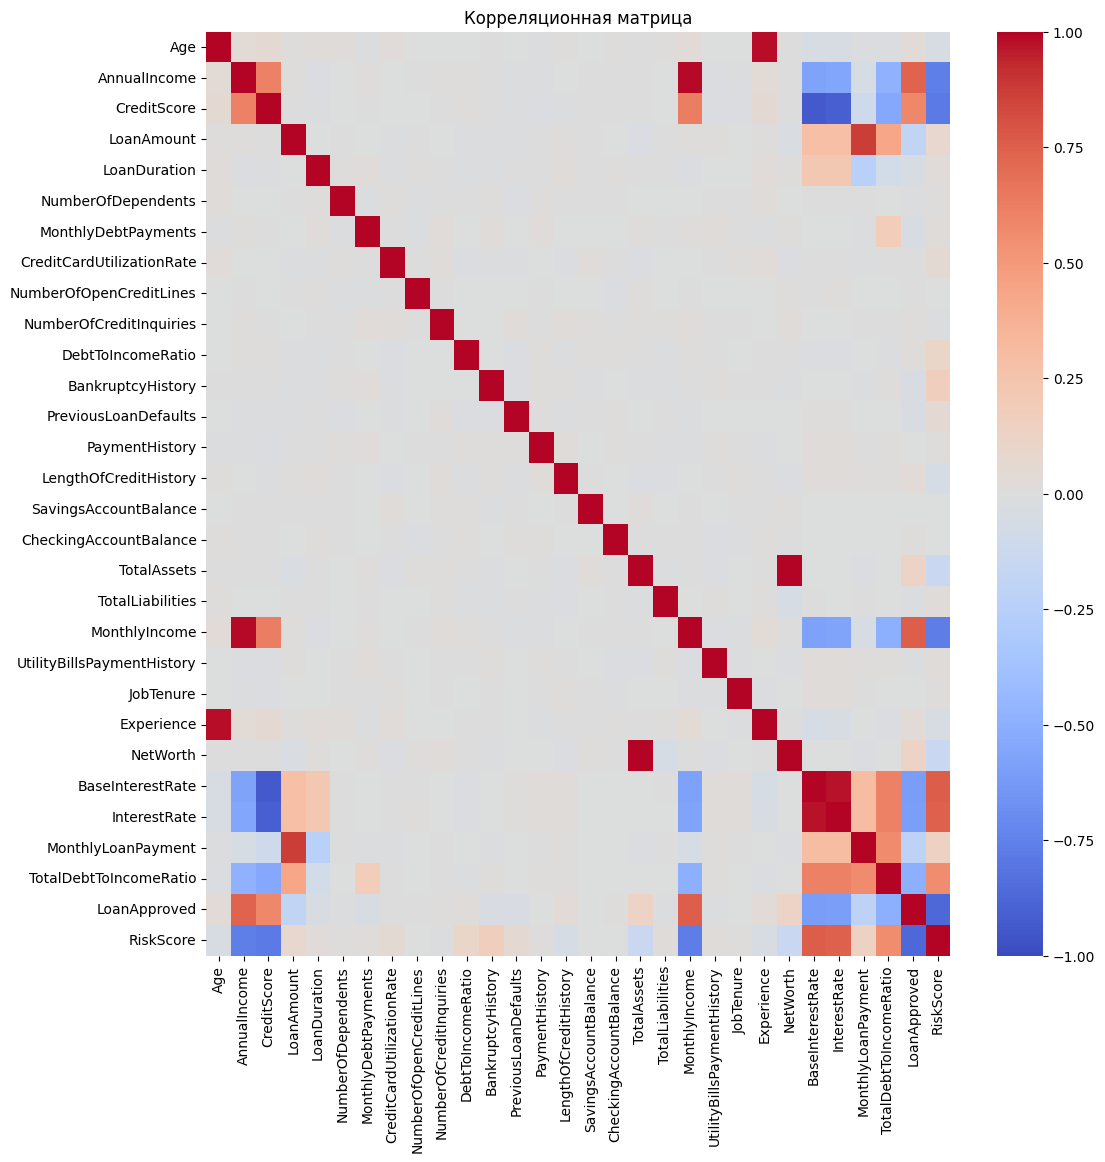

In [9]:
corr_matrix = df.select_dtypes(np.number).corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица")
plt.show()

In [10]:
high_corr = corr_matrix[(corr_matrix >= 0.8) & (corr_matrix != 1.)].stack()
print(high_corr)

Age                 Experience            0.982768
AnnualIncome        MonthlyIncome         0.984418
LoanAmount          MonthlyLoanPayment    0.868639
TotalAssets         NetWorth              0.993821
MonthlyIncome       AnnualIncome          0.984418
Experience          Age                   0.982768
NetWorth            TotalAssets           0.993821
BaseInterestRate    InterestRate          0.975284
InterestRate        BaseInterestRate      0.975284
MonthlyLoanPayment  LoanAmount            0.868639
dtype: float64


In [11]:
df.drop(columns=['Experience', 'MonthlyIncome', 'MonthlyLoanPayment', 'NetWorth', 'BaseInterestRate'])

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,UtilityBillsPaymentHistory,JobTenure,EmploymentStatus,EducationLevel,InterestRate,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,0.151985,2.0,1.0,0.168542,0.0,Education,0.0,23.0,5.0,2539.0,247.0,50072.0,15005.0,0.908289,4.0,Employed,Associate,0.251465,0.288013,0.0,66.176500
1,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,0.175693,3.0,0.0,0.141553,0.0,Home,0.0,27.0,11.0,844.0,694.0,91878.0,64877.0,0.797339,2.0,Employed,High School,0.093173,0.050585,1.0,28.495737
2,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,0.444605,3.0,0.0,0.030987,1.0,Education,0.0,21.0,12.0,12756.0,651.0,292300.0,13918.0,0.915945,3.0,Employed,Bachelor,0.115443,0.072571,1.0,34.488104
3,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,0.188452,7.0,0.0,0.379843,0.0,Debt Consolidation,0.0,27.0,21.0,1524.0,529.0,13070.0,3846.0,0.876416,3.0,Employed,High School,0.112822,0.225415,1.0,36.910753
4,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,0.273431,3.0,1.0,0.068659,0.0,Debt Consolidation,0.0,35.0,9.0,1973.0,128.0,33357.0,351603.0,0.888689,5.0,Employed,Bachelor,0.089037,0.052721,1.0,31.347091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,31.0,300000.0,850.0,14503.0,60.0,Married,2.0,Mortgage,185.0,0.056431,4.0,0.0,0.111624,0.0,Debt Consolidation,0.0,20.0,3.0,1661.0,1036.0,18926.0,78720.0,0.858575,4.0,Employed,Doctorate,0.113622,0.020118,1.0,34.037970
9995,27.0,15000.0,361.0,19505.0,36.0,Single,1.0,Other,622.0,0.409411,2.0,1.0,0.338705,0.0,Education,1.0,27.0,16.0,5427.0,6653.0,47008.0,15662.0,0.881564,5.0,Employed,High School,0.346203,1.200114,0.0,76.185933
9996,49.0,185082.0,573.0,7447.0,84.0,Married,0.0,Mortgage,946.0,0.095426,0.0,0.0,0.050347,0.0,Auto,0.0,19.0,26.0,12066.0,2543.0,55940.0,41924.0,0.857323,4.0,Employed,High School,0.235055,0.073099,1.0,41.213393
9997,55.0,296728.0,850.0,44162.0,84.0,Divorced,2.0,Mortgage,479.0,0.373804,6.0,0.0,0.363057,1.0,Education,0.0,22.0,19.0,15931.0,3863.0,19794.0,207416.0,0.822224,4.0,Employed,High School,0.144973,0.053333,1.0,43.699684


In [12]:
risk_corr = corr_matrix['RiskScore']
risk_corr[(risk_corr < 0.01) & (risk_corr > -0.01)]
#df.drop(columns=['SavingsAccountBalance'])

NumberOfDependents         0.008847
NumberOfOpenCreditLines   -0.001434
SavingsAccountBalance     -0.004013
CheckingAccountBalance    -0.006860
Name: RiskScore, dtype: float64

Закодируем категориальные признаки:

In [13]:
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Обучение модели
Используем линейную регрессию с регуляризацией Ridge. Используем StandardScaler для масштабирования признаков.
С помощью библиотеки Optuna подберем оптимальные гиперпараметры модели.

In [14]:
X_train = df.drop(columns=['RiskScore'])
Y_train = df['RiskScore']

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

In [15]:
def objective(trial, X=scaled_X, Y=Y_train):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
    params = {
        'alpha': trial.suggest_float('alpha', 0.0, 1.0),
        'tol': trial.suggest_float('tol', 1e-6, 1e-3),
    }
    model = Ridge(**params)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    score = mean_squared_error(Y_test, Y_pred)
    return score

In [16]:
study = optuna.create_study(direction="minimize")

# Optimize the objective function
study.optimize(objective, n_trials=100)

[I 2024-10-17 18:23:03,463] A new study created in memory with name: no-name-2907b16a-38ed-4c22-85c9-bb82d4f5dec0
[I 2024-10-17 18:23:03,512] Trial 0 finished with value: 18.523736383006394 and parameters: {'alpha': 0.5068617615642707, 'tol': 0.0006555868963830317}. Best is trial 0 with value: 18.523736383006394.
[I 2024-10-17 18:23:03,555] Trial 1 finished with value: 18.523133019575873 and parameters: {'alpha': 0.9853583042268601, 'tol': 0.000731010919005422}. Best is trial 1 with value: 18.523133019575873.
[I 2024-10-17 18:23:03,601] Trial 2 finished with value: 18.52313566934463 and parameters: {'alpha': 0.9832326469525292, 'tol': 8.66113458615642e-05}. Best is trial 1 with value: 18.523133019575873.
[I 2024-10-17 18:23:03,647] Trial 3 finished with value: 18.524148869349748 and parameters: {'alpha': 0.1859917418119471, 'tol': 0.0007704686533878605}. Best is trial 1 with value: 18.523133019575873.
[I 2024-10-17 18:23:03,710] Trial 4 finished with value: 18.523583551087555 and param

In [17]:
print("Best hyperparameters:", study.best_params)
print("Best value:", study.best_value)

Best hyperparameters: {'alpha': 0.9998329184037414, 'tol': 0.0007954340433003403}
Best value: 18.52311498322017


Визуализируем поиск гиперпараметров.

In [18]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [19]:
vis.plot_slice(study)

Обучим нашу модель с этими гиперпараметрами.

In [20]:
sk_reg = Ridge(**study.best_params)
sk_reg.fit(scaled_X, Y_train)
pred = sk_reg.predict(scaled_X)
pred

array([62.0474537 , 28.64534432, 37.67436162, ..., 36.20980588,
       42.48956844, 59.12751098])

In [21]:
print(mean_squared_error(pred, Y_train))

18.856446268184058


Отправим сабмит.

In [22]:
test = pd.read_csv('/kaggle/input/mai-ml-contest-1/test.csv')
test = test.dropna()

num_features = test.select_dtypes(include=np.number).columns.tolist()
cat_features = test.select_dtypes(include='object').columns.tolist()
cat_features.remove('ApplicationDate')
test = test.drop(columns=['ID', 'ApplicationDate'])
test = pd.get_dummies(test, columns=cat_features, drop_first=True)
test.drop(columns=['Experience', 'MonthlyIncome', 'MonthlyLoanPayment', 'NetWorth', 'BaseInterestRate'])
scaled_pred = pd.DataFrame(scaler.transform(test), columns=test.columns)
test_pred = sk_reg.predict(scaled_pred)
test_pred

array([32.63619184, 57.3770625 , 30.24310628, ..., 63.50114605,
       52.8008323 , 81.49492849])

In [23]:
submission = pd.DataFrame({'RiskScore': test_pred})
submission.to_csv('submission.csv', index=True, index_label='ID')